<a href="https://colab.research.google.com/github/erico-bachour/Challenge_Data_Science_2_Alura/blob/main/Insight_Places_2_Prepara%C3%A7%C3%A3o_e_Modelagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Imobiliária Insight Places - Modelo de Precificação**

A partir da base de dados fornecida pela Imobiliária Insight Places e das instruções da equipe da Data Science da mesma, chegamos a essa etapa do projeto de criação do modelo de precificação de imóveis e do recomendador de imóveis.

Feitas as filtragens, vamos ver como está a nossa nova base de dados.

Mas antes vamos preparar o ambiente com as devidas bibliotecas de apoio.

In [ ]:
!pip install pyspark==3.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 30 kB/s 
     |████████████████████████████████| 199 kB 44.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=f6bb153e4ddb1e03122ab9b07d8f958d3aa1df72ad09eeea6cb175ac199a7d57
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Transformação com Spark") \
    .getOrCreate()

spark

Com as bibliotecas de apoio baixadas, vamos partir para a base de dados:

In [ ]:
import zipfile
!wget 'https://caelum-online-public.s3.amazonaws.com/challenge-spark/semana-2.zip'

--2022-12-05 00:53:28--  https://caelum-online-public.s3.amazonaws.com/challenge-spark/semana-2.zip
Resolving caelum-online-public.s3.amazonaws.com (caelum-online-public.s3.amazonaws.com)... 52.217.8.84, 54.231.234.113, 52.217.168.9, ...
Connecting to caelum-online-public.s3.amazonaws.com (caelum-online-public.s3.amazonaws.com)|52.217.8.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2763652 (2.6M) [application/zip]
Saving to: ‘semana-2.zip’

semana-2.zip        100%[===================>]   2.63M  --.-KB/s    in 0.1s    

2022-12-05 00:53:28 (20.6 MB/s) - ‘semana-2.zip’ saved [2763652/2763652]



In [ ]:
!unzip -q semana-2.zip

In [ ]:
dataset = spark.read.parquet('/content/dataset_transformado_parquet')

In [ ]:
#mostrando a nova base dados:

dataset.limit(5).toPandas()

,id,andar,area_total,area_util,banheiros,caracteristicas,quartos,suites,tipo_anuncio,tipo_unidade,tipo_uso,vaga,bairro,zona,condominio,iptu,tipo,valor
0,03a386b6-7ab8-4eff-891d-f8a16efc1989,0,43,43,1,"[Churrasqueira, Academia, Playground, Salão de...",2,NaN,Usado,Apartamento,Residencial,1,Realengo,Zona Oeste,285,None,Venda,22999
1,1fe78d41-b8e0-4d21-a1a8-72cb7863f441,0,44,44,1,[],2,0.0,Usado,Apartamento,Residencial,0,Irajá,Zona Norte,170,0,Venda,110000
2,1fa1c1e5-e98c-433f-9675-1b43d7d6da01,4,None,55,1,[],2,0.0,Usado,Apartamento,Residencial,1,Cosmos,Zona Oeste,None,None,Venda,115000
3,a6ab01ae-3d40-40e7-bb6a-f2334e0abbe0,2,None,55,1,[],2,0.0,Usado,Apartamento,Residencial,0,Tomás Coelho,Zona Norte,None,None,Venda,115000
4,1d8ff7a2-16bd-4e3f-a92e-1b85f923ebb0,0,None,50,1,[],1,NaN,Usado,Apartamento,Residencial,0,Centro,Zona Central,1300,2679,Venda,125000


revendo quantas linhas temos no dataset:

In [ ]:
print('Número de linhas no arquivo: %s' % dataset.count())

Número de linhas no arquivo: 66562


In [ ]:
dataset.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: long (nullable = true)
 |-- area_total: string (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: string (nullable = true)



##**Tratamento de Variáveis**

### DataTypes

Analisando o .printSchema acima, podemos ver que muitas colunas numéricas estão errôneamente classificadas como 'string'. Dessa forma, vamos efetuar a conversão das mesmas para um formato numérico, seja ele SingleType ou DoubleType.

Podemos converter o tipo de colunas numéricas, como "andar", "banheiros", "suites" e "quartos" para o tipo inteiro. Além disso também pode ser necessário converter as colunas "area_util", "condominio", "iptu" e "valor" para o tipo double.

In [ ]:
from pyspark.sql.types import DoubleType, StringType, IntegerType
from pyspark.sql import functions as f

In [ ]:
colunas_inteiras = ['andar', 'banheiros', 'suites', 'quartos']
colunas_double = ['area_util','area_total', 'condominio', 'iptu', 'valor']

In [ ]:
for coluna in colunas_inteiras:
    dataset = dataset.withColumn(coluna, dataset[coluna].cast(IntegerType()))

for coluna in colunas_double:
   dataset = dataset.withColumn(coluna, dataset[coluna].cast(DoubleType()))

In [ ]:
dataset.printSchema()


root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_total: double (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: double (nullable = true)



Como padrão nos modelos de Machine Learning, vamos renomear a coluna 'valor', que é a variável dependente, com o nome de 'label'.

In [ ]:
dataset = dataset.withColumnRenamed('valor', 'label')

Passada a etapa de conversão das colunas, vamos selecionar as variáveis que farão parte no nosso modelo de precificação.

Como fizemos algumas filtragens na primeira parte do projeto, algumas colunas acabaram ficando com valores unicos, dessa forma, tornando-se irrelevantes para o modelo e serão excluídas.

In [ ]:
dataset=dataset\
    .select('*')\
    .drop('tipo', 'tipo_anuncio', 'tipo_unidade', 'tipo_uso')

In [ ]:
dataset.limit(5).toPandas()

,id,andar,area_total,area_util,banheiros,caracteristicas,quartos,suites,vaga,bairro,zona,condominio,iptu,label
0,03a386b6-7ab8-4eff-891d-f8a16efc1989,0,43.0,43.0,1,"[Churrasqueira, Academia, Playground, Salão de...",2,NaN,1,Realengo,Zona Oeste,285.0,NaN,22999.0
1,1fe78d41-b8e0-4d21-a1a8-72cb7863f441,0,44.0,44.0,1,[],2,0.0,0,Irajá,Zona Norte,170.0,0.0,110000.0
2,1fa1c1e5-e98c-433f-9675-1b43d7d6da01,4,NaN,55.0,1,[],2,0.0,1,Cosmos,Zona Oeste,NaN,NaN,115000.0
3,a6ab01ae-3d40-40e7-bb6a-f2334e0abbe0,2,NaN,55.0,1,[],2,0.0,0,Tomás Coelho,Zona Norte,NaN,NaN,115000.0
4,1d8ff7a2-16bd-4e3f-a92e-1b85f923ebb0,0,NaN,50.0,1,[],1,NaN,0,Centro,Zona Central,1300.0,2679.0,125000.0


Continuando o processo de limpeza, percebemos que duas colunas que merecem atenção são 'area_total' e 'area_util'. Como estamos lidando somente com apartamentos, as duas colunas acabam por se equivaler. Dessa forma, ficaremos somente com a que tiver o menor número de linhas vazias, pois não atrapalhará uma futura modelagem.

In [ ]:
print("Número de linhas vazias da coluna area_total: %s" % dataset.select('area_total').where('area_total==0').count())
print("Número de linhas vazias da coluna area_util: %s" % dataset.select('area_util').where('area_util==0').count())

Número de linhas vazias da coluna area_total: 9
Número de linhas vazias da coluna area_util: 0


Como pudemos ver na célula acima, ficaremos com a coluna 'area_util'.

In [ ]:
dataset = dataset\
      .select('*')\
      .drop('area_total')


In [ ]:
dataset.limit(5).toPandas()

,id,andar,area_util,banheiros,caracteristicas,quartos,suites,vaga,bairro,zona,condominio,iptu,label
0,03a386b6-7ab8-4eff-891d-f8a16efc1989,0,43.0,1,"[Churrasqueira, Academia, Playground, Salão de...",2,NaN,1,Realengo,Zona Oeste,285.0,NaN,22999.0
1,1fe78d41-b8e0-4d21-a1a8-72cb7863f441,0,44.0,1,[],2,0.0,0,Irajá,Zona Norte,170.0,0.0,110000.0
2,1fa1c1e5-e98c-433f-9675-1b43d7d6da01,4,55.0,1,[],2,0.0,1,Cosmos,Zona Oeste,NaN,NaN,115000.0
3,a6ab01ae-3d40-40e7-bb6a-f2334e0abbe0,2,55.0,1,[],2,0.0,0,Tomás Coelho,Zona Norte,NaN,NaN,115000.0
4,1d8ff7a2-16bd-4e3f-a92e-1b85f923ebb0,0,50.0,1,[],1,NaN,0,Centro,Zona Central,1300.0,2679.0,125000.0


### Coluna Características

Observando nosso DataFrame, podemos perceber que a coluna 'características' está montada de uma forma que atrapalha a modelagem, pois seus elementos estão organizados em listas. Isso impede uma contagem de cada característica individualmente.

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.sql.functions import *

vamos criar um novo dataframe somente com as caracteristicas em lista e a coluna 'id' para uma futura união.

In [ ]:
caracteristicas = dataset.select('id', 'caracteristicas')
caracteristicas.show(truncate=False)

+------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------+
|id                                  |caracteristicas                                                                                                                          |
+------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------+
|03a386b6-7ab8-4eff-891d-f8a16efc1989|[Churrasqueira, Academia, Playground, Salão de festas, Condomínio fechado, Portão eletrônico, Portaria 24h, Animais permitidos]          |
|1fe78d41-b8e0-4d21-a1a8-72cb7863f441|[]                                                                                                                                       |
|1fa1c1e5-e98c-433f-9675-1b43d7d6da01|[]                                                                           

In [ ]:
caracteristicas\
        .select("id", explode_outer("caracteristicas"))\
        .limit(10)\
        .show()

+--------------------+------------------+
|                  id|               col|
+--------------------+------------------+
|03a386b6-7ab8-4ef...|     Churrasqueira|
|03a386b6-7ab8-4ef...|          Academia|
|03a386b6-7ab8-4ef...|        Playground|
|03a386b6-7ab8-4ef...|   Salão de festas|
|03a386b6-7ab8-4ef...|Condomínio fechado|
|03a386b6-7ab8-4ef...| Portão eletrônico|
|03a386b6-7ab8-4ef...|      Portaria 24h|
|03a386b6-7ab8-4ef...|Animais permitidos|
|1fe78d41-b8e0-4d2...|              null|
|1fa1c1e5-e98c-433...|              null|
+--------------------+------------------+



In [ ]:
caracteristicas_explode = caracteristicas.select('id', explode_outer("caracteristicas"))

com a coluna 'caracteristicas' explodida em diversas colunas, vamos pivotar esse dataframe, sempre agrupado pelo 'id'. Dessa forma, o que eram linhas tornarão-se colunas.

In [ ]:
caracteristicas_2 = caracteristicas_explode.groupBy("id").pivot("col").count()
caracteristicas_pivot = caracteristicas_2.select('*')


In [ ]:
caracteristicas_pivot.printSchema()

root
 |-- id: string (nullable = true)
 |-- null: long (nullable = true)
 |-- Academia: long (nullable = true)
 |-- Animais permitidos: long (nullable = true)
 |-- Churrasqueira: long (nullable = true)
 |-- Condomínio fechado: long (nullable = true)
 |-- Elevador: long (nullable = true)
 |-- Piscina: long (nullable = true)
 |-- Playground: long (nullable = true)
 |-- Portaria 24h: long (nullable = true)
 |-- Portão eletrônico: long (nullable = true)
 |-- Salão de festas: long (nullable = true)



In [ ]:
caracteristicas_pivot.limit(5).toPandas()

,id,null,Academia,Animais permitidos,Churrasqueira,Condomínio fechado,Elevador,Piscina,Playground,Portaria 24h,Portão eletrônico,Salão de festas
0,fd96bbd5-d631-416a-9f84-29091cefe14c,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1
1,bfffedfe-99e7-4aed-9a9f-f766225a0f1f,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1,NaN,1.0,1
2,fcb67af3-5601-415f-9d1f-75280923a4e3,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1,NaN,NaN,1
3,afecddff-f4cc-4ab8-bdbf-242b7dff7241,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1
4,1bbc40f3-4f5c-4595-99b1-56ef42a54ede,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1,1.0,1.0,1


com o dataframe pivotado, vamos uní-lo com o principal, usando a coluna 'id' como chave e num segundo momento excluindo as colunas 'caracteristicas' e 'null', pois não serão úteis para o modelo.

In [ ]:
dataset = dataset.join(caracteristicas_pivot, on='id', how='outer')

In [ ]:
dataset = dataset.drop('caracteristicas', 'null')
dataset.show()

+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+----------+------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|              bairro|      zona|condominio|  iptu|    label|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+----------+------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|00012605-9cae-45b...|    0|    410.0|        3|      4|     1|   1|             Ipanema|  Zona Sul|    3300.0|5780.0|4600000.0|    null|              null|         null|              null|       1|   null

In [ ]:
dataset.count()

66562

## Lidando com dados nulos

Para conseguirmos elaborar um modelo de precificação adequado, precisamos resolver o problema dos dados nulos, pois os modelos não costumam trabalhar corretamente com dados faltantes.

Dessa forma, vamos substituir no dataset os valores nulos por 0.

In [ ]:
dataset.select('suites').groupBy('suites').count().show()

+------+-----+
|suites|count|
+------+-----+
|    12|    1|
|  null| 5554|
|     1|33889|
|     6|   27|
|     3| 3751|
|    20|    2|
|     5|  354|
|     4| 3026|
|     7|    3|
|     2| 7228|
|     0|12724|
|    10|    1|
|    21|    1|
|    30|    1|
+------+-----+



In [ ]:
dataset = dataset.fillna(0)
dataset.limit(5).toPandas()

,id,andar,area_util,banheiros,quartos,suites,vaga,bairro,zona,condominio,...,Academia,Animais permitidos,Churrasqueira,Condomínio fechado,Elevador,Piscina,Playground,Portaria 24h,Portão eletrônico,Salão de festas
0,00012605-9cae-45b3-82a2-f09d117fa7a4,0,410.0,3,4,1,1,Ipanema,Zona Sul,3300.0,...,0,0,0,0,1,0,0,0,0,0
1,0002dfaf-7735-481b-8523-8f59fb87e4e1,1,50.0,1,1,0,1,Vila Isabel,Zona Norte,500.0,...,0,1,0,0,1,0,0,0,1,1
2,0003ce76-949d-4841-90ec-7abea911ce6a,0,148.0,4,4,2,2,Jacarepaguá,Zona Oeste,0.0,...,0,0,1,0,1,1,0,0,0,0
3,00064277-de4c-4a31-8136-cd3dc86b0ac5,0,104.0,1,2,0,0,Copacabana,Zona Sul,1010.0,...,0,0,0,0,1,0,0,0,0,0
4,000be8fe-2044-4cec-a8f6-6853e56f2d5e,0,71.0,2,2,0,1,Humaitá,Zona Sul,1312.0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
dataset.select('suites').groupBy('suites').count().show()

+------+-----+
|suites|count|
+------+-----+
|    12|    1|
|     1|33889|
|     6|   27|
|     3| 3751|
|    20|    2|
|     5|  354|
|     4| 3026|
|     7|    3|
|     2| 7228|
|     0|18278|
|    10|    1|
|    21|    1|
|    30|    1|
+------+-----+



## Colunas Binárias

Numa próxima etapa, vamos transformar algumas colunas em binárias. Mas primeiro verificaremos se ela possui poucas respostas possíveis, o que possibilita a transformação em Dummy.

In [ ]:
dataset\
    .select('zona')\
    .groupBy('zona')\
    .count()\
    .show()

+------------+-----+
|        zona|count|
+------------+-----+
|  Zona Norte|11897|
|  Zona Oeste|32979|
|Zona Central| 1144|
|    Zona Sul|20531|
|            |   11|
+------------+-----+



como vimos que alguns registro não possuem zona, vamos proceder para eliminá-los

In [ ]:
dataset = dataset.filter(dataset.zona != "")
dataset.count()

66551

Com os dados nulos excluídos, vamos pivotar a coluna 'zona' para que as quatro zonas tornem-se colunas booleanas.

In [ ]:
zonas = dataset.groupBy("id").pivot("zona").count().fillna(0)
zonas.limit(2).show()


+--------------------+------------+----------+----------+--------+
|                  id|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+------------+----------+----------+--------+
|4e47e4d4-3326-4eb...|           0|         0|         0|       1|
|02fba6ef-a691-442...|           0|         0|         1|       0|
+--------------------+------------+----------+----------+--------+



In [ ]:
dataset = dataset.join(zonas, on='id', how='outer')
dataset = dataset.drop('zona')
dataset.limit(5).toPandas()

,id,andar,area_util,banheiros,quartos,suites,vaga,bairro,condominio,iptu,...,Elevador,Piscina,Playground,Portaria 24h,Portão eletrônico,Salão de festas,Zona Central,Zona Norte,Zona Oeste,Zona Sul
0,00012605-9cae-45b3-82a2-f09d117fa7a4,0,410.0,3,4,1,1,Ipanema,3300.0,5780.0,...,1,0,0,0,0,0,0,0,0,1
1,0002dfaf-7735-481b-8523-8f59fb87e4e1,1,50.0,1,1,0,1,Vila Isabel,500.0,600.0,...,1,0,0,0,1,1,0,1,0,0
2,0003ce76-949d-4841-90ec-7abea911ce6a,0,148.0,4,4,2,2,Jacarepaguá,0.0,0.0,...,1,1,0,0,0,0,0,0,1,0
3,00064277-de4c-4a31-8136-cd3dc86b0ac5,0,104.0,1,2,0,0,Copacabana,1010.0,272.0,...,1,0,0,0,0,0,0,0,0,1
4,000be8fe-2044-4cec-a8f6-6853e56f2d5e,0,71.0,2,2,0,1,Humaitá,1312.0,360.0,...,1,0,0,0,0,0,0,0,0,1


## Limpeza Extra

Analisando a consolidação da coluna andar, vemos alguns registros que não condizem com a realidade.

In [ ]:
dataset\
    .select('andar')\
    .filter('andar >= 50')\
    .groupBy('andar')\
    .count()\
    .show()

+-----+-----+
|andar|count|
+-----+-----+
|  300|    1|
|  280|    1|
|  504|    1|
| 1234|    8|
|  102|    1|
|   50|   31|
|  703|    1|
|   70|    2|
|  345|    1|
|  150|    1|
|  123|    5|
|   99|    6|
+-----+-----+



Após breve pesquisa na internet, descobriu-se que o maior edificio do Estado do Rio de Janeiro é o Rio Sul Center, que possui 48 andares, o que torna impossível a existência desses imóveis supracitados.

Dado que estamos lidando com uma amostra de mais de 60 mil, esses 59 imóveis não farão grande diferença nos resultados do modelo.

Assim, vamos prosseguir na exclusão desses registros.

In [ ]:
dataset_final = dataset.filter(dataset.andar < 49)
dataset.limit(5).toPandas()

,id,andar,area_util,banheiros,quartos,suites,vaga,bairro,condominio,iptu,...,Elevador,Piscina,Playground,Portaria 24h,Portão eletrônico,Salão de festas,Zona Central,Zona Norte,Zona Oeste,Zona Sul
0,00012605-9cae-45b3-82a2-f09d117fa7a4,0,410.0,3,4,1,1,Ipanema,3300.0,5780.0,...,1,0,0,0,0,0,0,0,0,1
1,0002dfaf-7735-481b-8523-8f59fb87e4e1,1,50.0,1,1,0,1,Vila Isabel,500.0,600.0,...,1,0,0,0,1,1,0,1,0,0
2,0003ce76-949d-4841-90ec-7abea911ce6a,0,148.0,4,4,2,2,Jacarepaguá,0.0,0.0,...,1,1,0,0,0,0,0,0,1,0
3,00064277-de4c-4a31-8136-cd3dc86b0ac5,0,104.0,1,2,0,0,Copacabana,1010.0,272.0,...,1,0,0,0,0,0,0,0,0,1
4,000be8fe-2044-4cec-a8f6-6853e56f2d5e,0,71.0,2,2,0,1,Humaitá,1312.0,360.0,...,1,0,0,0,0,0,0,0,0,1


##Salvando a base de dados

Com a base de dados montada, vamos salvá-la para que possamos usá-la futuramente nos nossos modelos e algoritmos

In [ ]:
dataset_final.write.parquet(
    path = '/content/drive/Challenge_Data_Science_2/dataset_finalizado/parquet',
    mode = 'overwrite'
)

Finalizada a parte de filtragem, limpeza e transformação da nossa base de dados, vamos passar para a etapa de vetorização das nossas variáveis (features) para o modelo de precificação.

In [ ]:
from pyspark.ml.feature import VectorAssembler

x = ['andar',
    'area_util',
    'banheiros',
    'quartos',
    'suites',
    'vaga',
    'condominio',
    'iptu',
    'Zona Central',
    'Zona Norte',
    'Zona Oeste',
    'Zona Sul',
    'Condomínio fechado',
    'Playground',
    'Portão eletrônico',
    'Piscina',
    'Animais permitidos',
    'Portaria 24h',
    'Elevador',
    'Academia',
    'Salão de festas',
    'Churrasqueira']

vect_features = VectorAssembler(inputCols = x, outputCol = 'features')
imoveis_vect = vect_features.transform(dataset_final)
dataset_vect = imoveis_vect.select('features', 'label')

dataset_vect.show(5, truncate=False)

+--------------------------------------------------------------------------------------------+--------+
|features                                                                                    |label   |
+--------------------------------------------------------------------------------------------+--------+
|[0.0,43.0,1.0,2.0,0.0,1.0,285.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0]|22999.0 |
|(22,[1,2,3,6,9],[44.0,1.0,2.0,170.0,1.0])                                                   |110000.0|
|(22,[0,1,2,3,5,10],[4.0,55.0,1.0,2.0,1.0,1.0])                                              |115000.0|
|(22,[0,1,2,3,9],[2.0,55.0,1.0,2.0,1.0])                                                     |115000.0|
|(22,[1,2,3,6,7,8],[50.0,1.0,1.0,1300.0,2679.0,1.0])                                         |125000.0|
+--------------------------------------------------------------------------------------------+--------+
only showing top 5 rows



## **Análise de Correlação**

Antes de inserir os dados no modelo, vamos verificar a correlação entre as variáveis que a compõem. Caso haja algum caso de correlação alta, procederemos com a exclusão de uma das colunas, pois manter as duas siginificaria 'imputar' a mesma informação duas vezes no modelo, o que aumentaria a variância das previsões.

In [ ]:
from pyspark.ml.stat import Correlation
import pandas as pd

In [ ]:
correlacao = Correlation.corr(dataset_vect, 'features').collect()

In [ ]:
correlacao

[Row(pearson(features)=DenseMatrix(22, 22, [1.0, 0.0462, 0.0095, -0.0096, 0.0327, 0.0345, 0.0267, 0.0016, ..., 0.3162, 0.7521, 0.3105, 0.3723, 0.3802, 0.6761, 0.6476, 1.0], False))]

In [ ]:
correlacao = Correlation.corr(dataset_vect, 'features').collect()[0][0]

In [ ]:
correlacao

DenseMatrix(22, 22, [1.0, 0.0462, 0.0095, -0.0096, 0.0327, 0.0345, 0.0267, 0.0016, ..., 0.3162, 0.7521, 0.3105, 0.3723, 0.3802, 0.6761, 0.6476, 1.0], False)

In [ ]:
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns=x, index=x)

In [ ]:
dataframe_correlacao

,andar,area_util,banheiros,quartos,suites,vaga,condominio,iptu,Zona Central,Zona Norte,...,Condomínio fechado,Playground,Portão eletrônico,Piscina,Animais permitidos,Portaria 24h,Elevador,Academia,Salão de festas,Churrasqueira
andar,1.000000,0.046198,0.009455,-0.009635,0.032725,0.034510,0.026720,0.001615,0.121550,-0.010744,...,0.308178,0.168621,0.355281,0.131943,0.350930,0.380609,0.244818,0.202036,0.184248,0.137387
area_util,0.046198,1.000000,0.670963,0.673997,0.620033,0.471716,0.045691,0.021330,-0.103781,-0.170427,...,-0.012613,-0.015780,-0.001932,0.018153,-0.013085,-0.024327,0.016930,0.002008,-0.026989,-0.024059
banheiros,0.009455,0.670963,1.000000,0.648891,0.739751,0.444756,0.027208,0.013936,-0.125419,-0.163967,...,-0.005387,0.066205,-0.016378,0.099122,-0.024656,-0.034841,0.057167,0.079168,0.055745,0.042615
quartos,-0.009635,0.673997,0.648891,1.000000,0.579728,0.430165,0.021662,0.017248,-0.162725,-0.120688,...,-0.000387,0.077624,-0.015508,0.082614,-0.021275,-0.022393,0.025686,0.061236,0.060723,0.061367
suites,0.032725,0.620033,0.739751,0.579728,1.000000,0.457883,0.029088,0.011826,-0.103890,-0.215384,...,0.139045,0.188886,0.089883,0.263994,0.065415,0.080245,0.120113,0.242672,0.173670,0.185516
vaga,0.034510,0.471716,0.444756,0.430165,0.457883,1.000000,0.025896,0.011977,-0.098112,-0.105472,...,0.079531,0.133475,0.046517,0.170411,0.038533,0.035094,0.061499,0.139895,0.133168,0.131533
condominio,0.026720,0.045691,0.027208,0.021662,0.029088,0.025896,1.000000,0.202201,-0.004420,-0.010110,...,0.012329,0.009582,0.006178,0.010028,0.012591,0.011997,0.013399,0.014321,0.009145,0.005718
iptu,0.001615,0.021330,0.013936,0.017248,0.011826,0.011977,0.202201,1.000000,-0.003637,-0.008721,...,-0.005231,0.000794,-0.004485,0.002501,-0.001875,-0.001195,0.006523,0.003359,0.001128,-0.003078
Zona Central,0.121550,-0.103781,-0.125419,-0.162725,-0.103890,-0.098112,-0.004420,-0.003637,1.000000,-0.061697,...,0.047252,-0.002906,0.043298,0.013599,0.054959,0.049477,0.037947,0.043168,0.008755,0.001966
Zona Norte,-0.010744,-0.170427,-0.163967,-0.120688,-0.215384,-0.105472,-0.010110,-0.008721,-0.061697,1.000000,...,-0.089529,-0.036435,-0.032204,-0.133882,-0.025925,-0.072634,-0.027633,-0.120873,-0.018486,-0.050968


Para facilitar a visualização, vamos inserir um mapa de calor nessa matriz de correlação.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

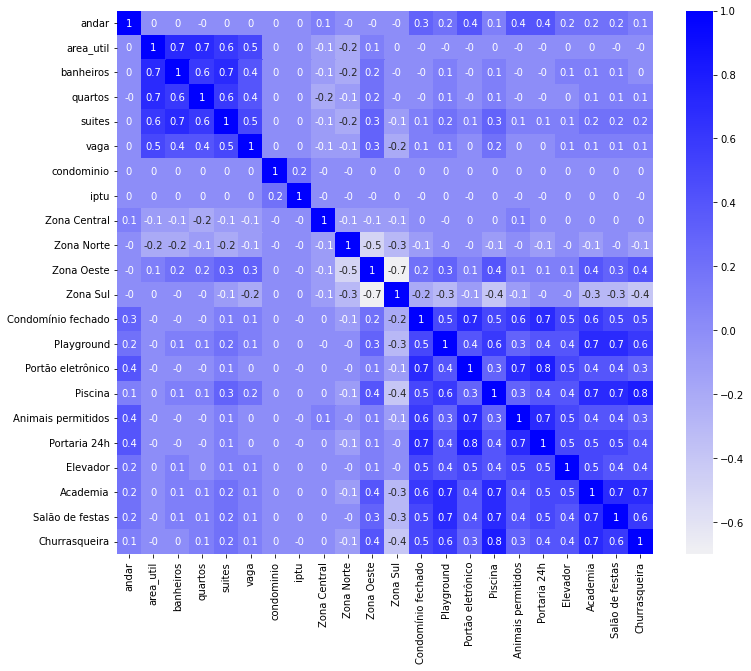

In [ ]:
plt.figure(figsize=(12,10))
paleta = sns.color_palette('light:blue', as_cmap=True)
sns.heatmap(dataframe_correlacao.round(1), annot=True, cmap=paleta)

Como não temos nenhum valor de correlação próximo a 0.9, não excluiremos nenhuma feature da nossa base de dados.

## **Modelos de Regressão**

##Regressão Linear##

Como primeiro modelo, vamos rodar uma Regressão Linear para ver como ela se comportar com a nossa base de dados.

In [ ]:
from pyspark.ml.regression import LinearRegression

Antes de rodar os modelos, vamos dividir a base de dados em treino e teste.

In [ ]:
treino, teste = dataset_vect.randomSplit([0.7, 0.3], seed=100)

In [ ]:
treino.count()

46555

In [ ]:
teste.count()

19937

In [ ]:
lr = LinearRegression()

In [ ]:
modelo_lr = lr.fit(treino)

Com o modelo 'fitado' aos dados, vamos partir para as previsões

In [ ]:
previsoes_lr_treino = modelo_lr.transform(treino)

In [ ]:
previsoes_lr_treino.limit(5).show()

+--------------------+--------+-----------------+
|            features|   label|       prediction|
+--------------------+--------+-----------------+
|(22,[0,1,2,3,4,5,...|629000.0|772556.4096014949|
|(22,[0,1,2,3,4,5,...|445000.0|669254.9790037455|
|(22,[0,1,2,3,4,5,...|539000.0|646595.5875506172|
|(22,[0,1,2,3,4,5,...|262000.0|753010.5793610114|
|(22,[0,1,2,3,4,5,...|115000.0|285119.5196443312|
+--------------------+--------+-----------------+



## Métricas de Avaliação

Para avaliar a eficiência ou não do modelo, vamos utilizar duas métricas: o R² (R-Quadrado) e o RMSE (Root Mean Squarred Error). O primeiro mede o quanto o modelo está ajustado aos dados, já o segundo mede os erros do modelo e não o modelo em si.

In [ ]:
resumo_treino = modelo_lr.summary

In [ ]:
resumo_treino.r2

0.6570089968534134

In [ ]:
resumo_treino.rootMeanSquaredError

864908.9551752538

In [ ]:
resumo_teste = modelo_lr.evaluate(teste)

In [ ]:
resumo_teste.r2

0.6850474276634951

In [ ]:
resumo_teste.rootMeanSquaredError

819334.7666387704

Agora vamos agregar esses dados em uma tabela

In [ ]:
print('Regressão Linear')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % resumo_treino.r2)
print("RMSE: %f" % resumo_treino.rootMeanSquaredError)
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % resumo_teste.r2)
print("RMSE: %f" % resumo_teste.rootMeanSquaredError)

Regressão Linear
Dados de Treino
R²: 0.657009
RMSE: 864908.955175

Dados de Teste
R²: 0.685047
RMSE: 819334.766639


##Arvore de Decisão

Como alternativa, vamos testar outros modelos de regressão para ver se eles se comportam melhor com nossa base de dados. Começando pelo modelo de Árvore de Decisão.

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

In [ ]:
dtr = DecisionTreeRegressor(seed=100, maxDepth=7)

In [ ]:
modelo_dtr = dtr.fit(treino)

In [ ]:
previsoes_dtr_treino = modelo_dtr.transform(treino)

In [ ]:
previsoes_dtr_treino.limit(5).show()

+--------------------+--------+-----------------+
|            features|   label|       prediction|
+--------------------+--------+-----------------+
|(22,[0,1,2,3,4,5,...|629000.0| 560293.165784459|
|(22,[0,1,2,3,4,5,...|445000.0|379455.9124548737|
|(22,[0,1,2,3,4,5,...|539000.0|379455.9124548737|
|(22,[0,1,2,3,4,5,...|262000.0| 560293.165784459|
|(22,[0,1,2,3,4,5,...|115000.0|379455.9124548737|
+--------------------+--------+-----------------+



##Métricas de Avaliação

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
evaluator = RegressionEvaluator()

print("R2: %s" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %s" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))

R2: 0.8035499521342946
RMSE: 654568.4958794373


In [ ]:
previsoes_dtr_teste = modelo_dtr.transform(teste)

In [ ]:
previsoes_dtr_teste.limit(5).show()

+--------------------+---------+-----------------+
|            features|    label|       prediction|
+--------------------+---------+-----------------+
|(22,[0,1,2,3,4,5,...| 600000.0| 560293.165784459|
|(22,[0,1,2,3,4,5,...| 400000.0|379455.9124548737|
|(22,[0,1,2,3,4,5,...| 790000.0|719874.5835380836|
|(22,[0,1,2,3,4,5,...| 755000.0|719874.5835380836|
|(22,[0,1,2,3,4,5,...|1047795.0|719874.5835380836|
+--------------------+---------+-----------------+



Consolidando as informações:

In [ ]:
print('Regressão por Árvore de Decisão')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))


Regressão por Árvore de Decisão
Dados de Treino
R²: 0.803550
RMSE: 654568.495879

Dados de Teste
R²: 0.777008
RMSE: 689419.449628


Analisando os números de R-quadrado e do RMSE, obtivemos melhorias em comparação com os da Regressão Linear, pois temos um numero maior de R-Quadrado e uma raiz do erro quadrado menor.

Apesar disso, vamos testar outros modelos para ver se encontramos alternativas ainda melhores.

##Random Forest

Outro modelo que podemos usar é o de Random Forrest. Ele nada mais é do que a agregação de várias árvores de decisão, o que o torna mais preciso nas regressões, porém com um custo maior de tempo e processamento computacional.

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(seed=100, maxDepth=7, numTrees=10)

In [ ]:
modelo_rfr = rfr.fit(treino)

In [ ]:
previsoes_rfr_treino = modelo_rfr.transform(treino)

In [ ]:
previsoes_rfr_treino.limit(5).show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(22,[0,1,2,3,4,5,...|629000.0| 560215.6464033049|
|(22,[0,1,2,3,4,5,...|445000.0|428667.36377591983|
|(22,[0,1,2,3,4,5,...|539000.0| 430591.5874386422|
|(22,[0,1,2,3,4,5,...|262000.0| 585222.1424217133|
|(22,[0,1,2,3,4,5,...|115000.0| 402008.6946131499|
+--------------------+--------+------------------+



##Métricas de Avaliação

In [ ]:
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))

0.8112068967275745
641685.3026216191


In [ ]:
previsoes_rfr_teste = modelo_rfr.transform(teste)

In [ ]:
previsoes_rfr_teste.limit(5).show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...| 600000.0| 612217.3173588592|
|(22,[0,1,2,3,4,5,...| 400000.0|453255.42237586586|
|(22,[0,1,2,3,4,5,...| 790000.0|  605369.737147045|
|(22,[0,1,2,3,4,5,...| 755000.0| 615703.7635054996|
|(22,[0,1,2,3,4,5,...|1047795.0|  605369.737147045|
+--------------------+---------+------------------+



consolidando os dados:

In [ ]:
print('Regressão por Random Forest')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))

Regressão por Random Forest
Dados de Treino
R²: 0.811207
RMSE: 641685.302622

Dados de Teste
R²: 0.795984
RMSE: 659434.104815


Novamente, obtivemos melhorias em relação a Árvore de Decisão, apesar de pequenas. Vamos continuar buscando novas formas de ajustar o modelo para que ele melhor se comporte com os dados.

## **Técnicas de Otimização**

##Cross Validation


A técnica conhecida como cross validation (validação cruzada) atua através da separação do conjunto de dados em k grupos, no qual um grupo será utilizado para teste e os restantes para treinamento do modelo. Ao realizar o primeiro treinamento, é selecionado um grupo para teste diferente do utilizado a princípio e o restante dos grupos é utilizado para treinamento.

###Árvore de Decisão

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
dtr = DecisionTreeRegressor()

In [ ]:
grid = ParamGridBuilder() \
      .addGrid(dtr.maxDepth, [2, 5, 10]) \
      .addGrid(dtr.maxBins, [10, 32, 45]) \
      .build()

In [ ]:
evaluator = RegressionEvaluator()

In [ ]:
dtr_cv = CrossValidator(
    estimator=dtr,
    estimatorParamMaps=	grid,
    evaluator=evaluator,
    numFolds=3,
    seed= 100
)

In [ ]:
modelo_dtr_cv = dtr_cv.fit(treino)

In [ ]:
previsoes_dtr_cv_teste = modelo_dtr_cv.transform(teste)

In [ ]:
print('Regressão por Árvore de Decisão')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "rmse"}))

Regressão por Árvore de Decisão
Sem Cross Validation
R²: 0.777008
RMSE: 689419.449628

Com Cross Validation
R²: 0.792169
RMSE: 665569.745327


###Random Forest

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor()

In [ ]:
grid = ParamGridBuilder() \
      .addGrid(rfr.numTrees, [10, 20, 30]) \
      .addGrid(rfr.maxDepth, [5, 10])\
      .addGrid(rfr.maxBins, [10, 32, 45]) \
      .build()

maxBins = quanto maior o numero, mais refinada são as tentativas de gerar os melhores nós

In [ ]:
evaluator = RegressionEvaluator()

In [ ]:
rfr_cv = CrossValidator(
    estimator = rfr,
    estimatorParamMaps=grid,
    evaluator = evaluator,
    numFolds = 3
)

In [ ]:
modelo_rfr_cv = rfr_cv.fit(treino)

In [ ]:
previsoes_rfr_cv_teste = modelo_rfr_cv.transform(teste)

In [ ]:
print('Regressão por Random Forest')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "rmse"}))

Regressão por Random Forest
Sem Cross Validation
R²: 0.795984
RMSE: 659434.104815

Com Cross Validation
R²: 0.831812
RMSE: 598737.838350


Como podemos ver nas consolidações das métricas, o melhor modelo dentre os testados foi o de Random Forrest com Cross Validation, pois ele apresenta o maior R-Quadrado e o menor RMSE.